In [ ]:
import pandas as pd


consumo_2024 = pd.read_excel(
    './Datos_consumos/CONSUMO-HIDROCARBUROS-2024-12.xlsx',
    sheet_name='CONSUMO',
    header=6,
    parse_dates=['Fecha']
)

consumo_2025 = pd.read_excel(
    './Datos_consumos/VENTAS-HIDROCARBUROS-2025-05.xlsx',
    sheet_name='VENTAS_IMP',
    header=6,
    parse_dates=['Fecha']
)

# Concatenar y ordenar por fecha
consumo = pd.concat([consumo_2024, consumo_2025], ignore_index=True)
consumo.sort_values('Fecha', inplace=True)
consumo.set_index('Fecha', inplace=True)

# Sumar columnas de diésel
diesel_cols = [c for c in consumo.columns if 'Diesel' in c]
consumo['Diesel'] = consumo[diesel_cols].sum(axis=1)

# Filtrar solo la serie Diesel
serie = consumo[['Diesel']].copy()
serie.dropna(inplace=True)


In [20]:
import numpy as np
print((serie['Diesel'] <= 0).sum(), "valores menores o iguales a 0")
serie = serie[serie['Diesel'] > 0]  # Solo valores positivos
serie['LogDiesel'] = np.log(serie['Diesel'])



0 valores menores o iguales a 0


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

serie['LogDiesel'] = np.log(serie['Diesel'])

scaler = MinMaxScaler()
serie['Escalado'] = scaler.fit_transform(serie[['LogDiesel']])


In [23]:
def crear_secuencias(data, ventana):
    X, y = [], []
    for i in range(len(data) - ventana):
        X.append(data[i:i+ventana])
        y.append(data[i+ventana])
    return np.array(X), np.array(y)

ventana = 12
serie_valores = serie['Escalado'].values
X, y = crear_secuencias(serie_valores, ventana)


In [24]:
from sklearn.model_selection import train_test_split

X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM necesita 3D

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

modelo1 = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

modelo1.compile(optimizer='adam', loss='mse')

historial1 = modelo1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1435 - val_loss: 0.0156
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - val_loss: 0.0178
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - val_loss: 0.0207
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - val_loss: 0.0146
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0171
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0138
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - val_loss: 0.0138
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - val_loss: 0.0138
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 0.0135
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - val_loss: 0.0138
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - val_loss: 

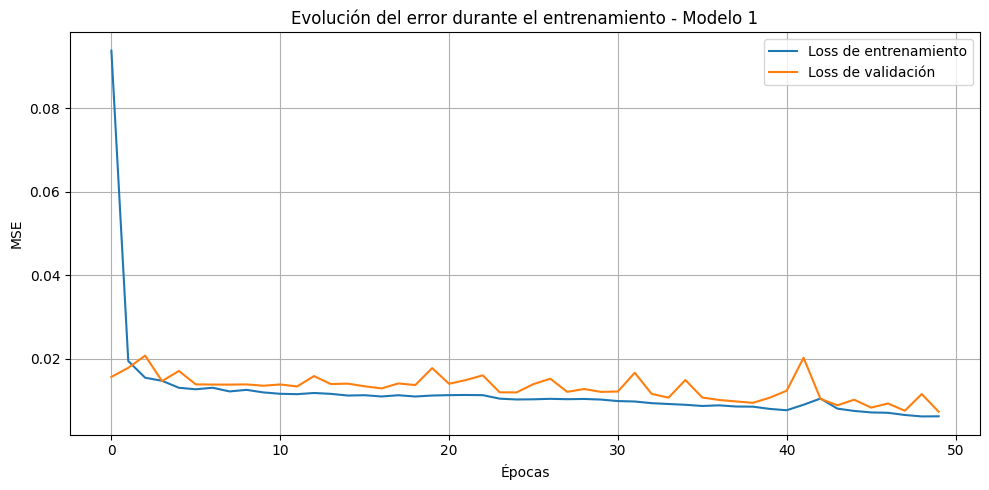

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(historial1.history['loss'], label='Loss de entrenamiento')
plt.plot(historial1.history['val_loss'], label='Loss de validación')
plt.title('Evolución del error durante el entrenamiento - Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se observa como este primer modelo desde las primeras épocas tanto la pérdida de entrenamiento como la validación disminuyen rápidamente, por lo que se deduce que el modelo aprende patrones significativos de la serie. A partir de la 5ta época las dos curvas se estabilizan lo que sugiere que el modelo generaliza bien.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

modelo2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

modelo2.compile(optimizer='adam', loss='mse')

historial2 = modelo2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50


C:\Users\irvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0985 - val_loss: 0.0300
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0220 - val_loss: 0.0361
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - val_loss: 0.0138
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0146
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - val_loss: 0.0158
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0130 - val_loss: 0.0156
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0130 - val_loss: 0.0146
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0132 - val_loss: 0.0139
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0132 - val_l

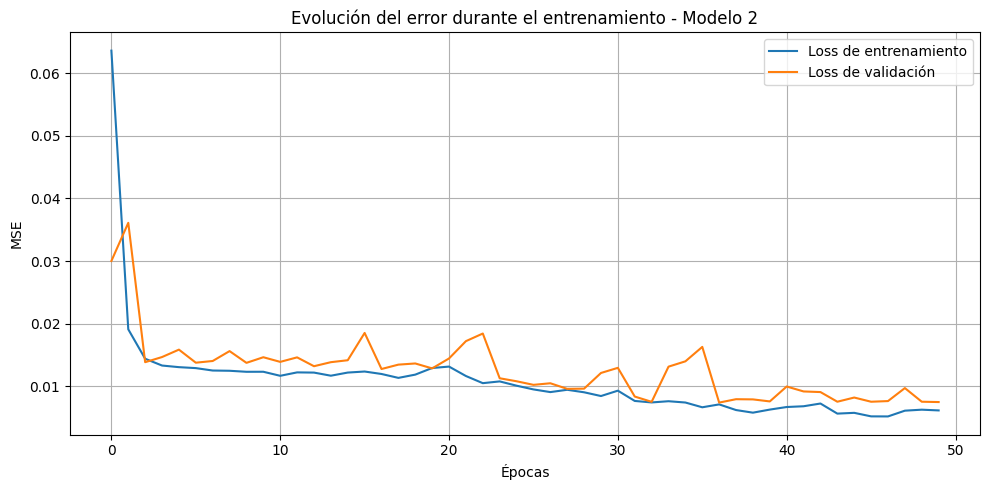

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(historial2.history['loss'], label='Loss de entrenamiento')
plt.plot(historial2.history['val_loss'], label='Loss de validación')
plt.title('Evolución del error durante el entrenamiento - Modelo 2')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Para el segundo modelo se optó por una arquitectura más profunda con Dropout y dos capas LSTM encadenas. Al compararlo con el primer modelo se obsra una pérdida de valifación ligeramente inferior en algunas etapas del entrenamiento.
Algo a notar es que la pérdida de validación se mantiene cerca a la entrenamiento, lo que sugiera eu el Dropout funciona como regulizadora.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred_1 = modelo1.predict(X_test)
y_pred_2 = modelo2.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_1_inv = scaler.inverse_transform(y_pred_1)
y_pred_2_inv = scaler.inverse_transform(y_pred_2)

def calcular_metricas(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    return rmse, mae

rmse_1, mae_1 = calcular_metricas(y_test_inv, y_pred_1_inv)
rmse_2, mae_2 = calcular_metricas(y_test_inv, y_pred_2_inv)

print(f"Modelo 1 - RMSE: {rmse_1:.4f} | MAE: {mae_1:.4f}")
print(f"Modelo 2 - RMSE: {rmse_2:.4f} | MAE: {mae_2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002B7E6BE5760> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
Modelo 1 - RMSE: 0.1183 | MAE: 0.0993
Modelo 2 - RMSE: 0.0981 | MAE: 0.0748


Al comparar las métricas de ambos modelos: RMSE y MAE, se observa como el segundo modelo tiene valores más bajos en comparación al primero, lo cual se traduce en un mejor rendimiento.  
Este segundo modelos posee una arquitectura más robusta al contar con dos capas LSTM y una regularización con Dropout, gracias a estas mejoras el modelo pudo capturar de manera más efectiva las dinámicas temporales de la serie. Esto se puede observar de manera gráfica con las dos figruas anteriormente mostradas.

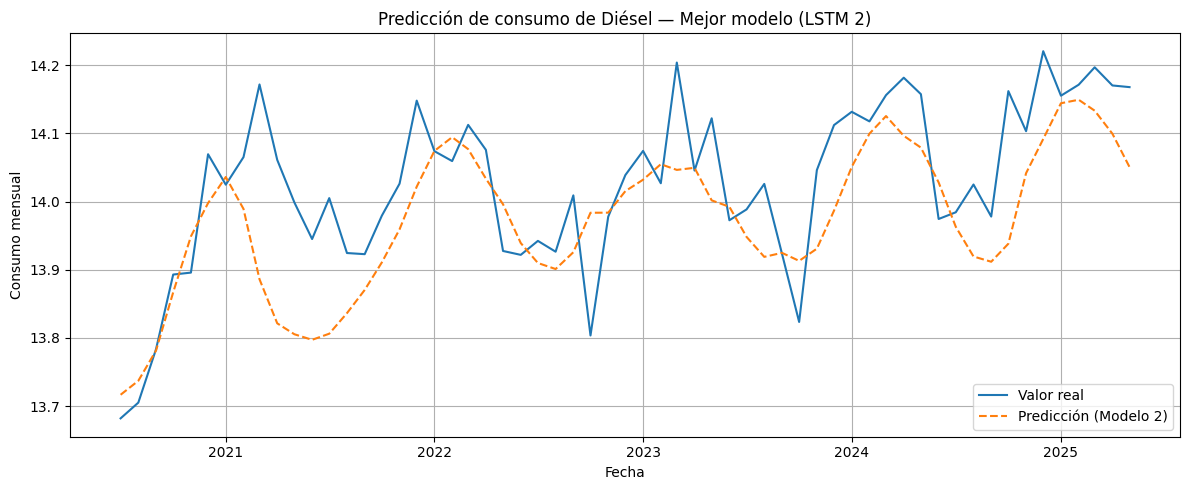

In [ ]:
fechas_test = serie.index[-len(y_test):]
fechas_test = pd.to_datetime(fechas_test)

fechas_test = pd.to_datetime(fechas_test)

import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(fechas_test, y_test_inv, label='Valor real')
plt.plot(fechas_test, y_pred_2_inv, label='Predicción (Modelo 2)', linestyle='--')

plt.title('Predicción de consumo de Diésel — Mejor modelo (LSTM 2)')
plt.xlabel('Fecha')
plt.ylabel('Consumo mensual')
plt.legend()
plt.grid(True)

# Mostrar una etiqueta por año
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Al observar de manera gráfica el rendimiento del modelo podemos observar como logra adaptarse correctamente a la tendencia, pero con un alto margen de mejora ya que generaliza de más creando predicciones que pueden llegar a ser ligeramente bagas.

## Compración con modelos del laboratorio anterior

La comparación de los modelos se hizo a partir de dos métricas principales: el RMSE (Root Mean Squared Error) y la MAE (Mean Absolute Error) que permiten medir la precisión de las predicciones de manera absoluta. Se consideró la capacidad del modelo para captar los patrones de tendencia, estacionalidad y cambios drásticos. Conestas consideraciones el modelo Prophet entrenado sobre la serie de consumo de diesel obtuvo el RMSE de aproximadamente 95,066 mientras que el LSTM deep learning obtuvo el RMSE de 98,100. Si bien ambos modelos fueron similares en desempeño, Prophet fue mejor entrenado en la captura de la estacionalidad anual y en la producción de predicciones más estables y explicable, mientras que el modelo LSTM mostró un buen desempeño en la captura de patrones no lineales aunque su predicción tiende a suavizar fluctaciones. Basandonos en estas métricas, es posible concluir que el modelo Prophet fue el mejor modelo para la serie de consumo de diesel, aunque el modelo LSTM deep learning representa una alternativa competitiva que (probablemente) con un mejor tuneo de parámetros o más capas podría igualar e incluso superar al Prophet.